The following jupyter allows us to analise and fit the retrieved data.

In [1]:
import cmath
import math
from iminuit.cost import LeastSquares
from iminuit import cost
import time
from iminuit import Minuit, cost
import numpy as np
from matplotlib import pyplot as plt
import h5py
from PIL import Image
import scipy.special as ss
import scipy.constants as sc

def ampl(i, q):
    return np.power((np.power(q, 2) + np.power(i, 2)), 1/2)

def phase(i, q):
    return(np.arctan(q / i))

def amp_model(x, p1 , p2 , p3, p4, p5, p6,  p7, p8):
    return (p6*(x) + p7*x**2 + p8*x**3) + abs(p1*(1 - cmath.exp(1j*p4)*p2*(p2**-1 - p3**-1) / (1 + 2j * p2 * ( x - p5 ) / f_min[0] )))

def new_amp_model(x, p1, p2 , p3, p4, p5, p6,  p7, p8):
    return (p6*x + p7*x**2 + p8*x**3) + p1 * abs ((1 - (1 - p2 / p3) * cmath.exp(1j*p4) / (1 + 2j * p2 * ( x - p5 ) / p5 )))

def inv_Qi_model(x, p1, p2, p3, p4):        
    return  1/p1 + (2*p2*np.exp(-p3/(sc.k*x))*2*np.sinh(sc.hbar*p4/(2*sc.k*x))*ss.kv(0, sc.hbar*p4/(2*sc.k*x)))/(np.pi*(1-2*np.exp(-p3/(sc.k*x))*np.exp(-sc.hbar*p4/(2*sc.k*x))*ss.iv(0,sc.hbar*p4/(2*sc.k*x))))

def plot_amp_and_phase(i, q, f, number_res):        #Plots the amplitude vs f and phase vs f for a single resonator given the i, q, f values
    fig, (ax1, ax2) = plt.subplots(1, 2)            #And that's for the resonator number 'number_res + 1'
    fig.suptitle("Plots relative to the resonator number " + str(number_res + 1) + "\n\n\n")

    ax1.plot(f, amp, label = 'Amplitude vs f')
    ax1.set_title( "Amplitude")
    ax1.set_xlabel("f [GHz]")
    ax1.set_ylabel("Amplitude")

    fig.subplots_adjust(wspace=.4)

    ax2.set_title("Phase")
    ax2.set_xlabel("f [GHz]")
    ax2.set_ylabel("$\Phi \; [rad]$")

    plt.plot(f, phase(i, q), label = 'Phase vs f')
    plt.show()
    
def get_single_res_data(h5file, temp, freq_window, number_res):     # Allows to get important data from the hdf5 file
    f1 = freq_window[number_res * 2]
    f2 = freq_window[number_res * 2 + 1]
    f = h5file['Temp_' + str(temp) + 'mK']['temp_' + str(temp) + 'mK_Start' + str(f1) + '_Stop' + str(f2) + 'GHz']['freqs'][number_res, :]*1e9
    i = h5file['Temp_' + str(temp) + 'mK']['temp_' + str(temp) + 'mK_Start' + str(f1) + '_Stop' + str(f2) + 'GHz']['I'][:]
    q = h5file['Temp_' + str(temp) + 'mK']['temp_' + str(temp) + 'mK_Start' + str(f1) + '_Stop' + str(f2) + 'GHz']['Q'][:]
    return f, i, q

def plot_data_and_fit(freqs, original_data, fitted_points, original_data_err = 0., x_axis = 'frequency [Hz]', y_axis = 'magnitude $S_{21}$', title = 'Amplitude vs frequency'):     # Plots superposition of fit and data
    plt.errorbar(freqs, original_data, yerr = original_data_err, xerr=None, marker='o', markersize=.8, barsabove=True, elinewidth=.8, capsize=.8, linewidth=0, label = 'data')
    plt.title(title)
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.plot(freqs, fitted_points, label = 'fit')
    #plt.title('Superposition of original data and fit')
    plt.show()

def fit_check(m):
    valid, accurate = m.valid, m.accurate
    return valid, accurate

def new_fit(f, amp, amp_err, new_amp_model): # new fit which is performed without frequency tranlsation
    least_squares = LeastSquares(f, amp, amp_err, new_amp_model)
    m = Minuit(least_squares, p1 = 1, p2 = 1e4, p3 = 6e4, p4 = -0.5, p5 = 5.5, p6 = -1e2,  p7 = -5e4, p8 = 1e-1)  # starting values for our parameters
    m.limits['p2'] = (1e3, 1e7)
    m.limits['p3'] = (1e3, 1e7)
    m.limits['p5'] = (5.2, 6.0)    
    fit = m.migrad()        #This is the command that performs the fit
    return fit, m  

freq_window = np.array([5.340, 5.355, 5.568, 5.583, 5.667, 5.682, 5.978, 5.987])
    

First of all we decide what uncertainty assign to every measure of the $S_{21}$ module. We acquired data using two different bandwidth settings: $10Hz$ and $30Hz$. In particular, we have data for temperatures between $33mK$ and $260mK$. Much of that (multiples of $5$ from $35mK$ to $115mK$ circa) have been acquired in the cleanest way possible, by using the lowest bandwidth. How can we set up errors so they account for this difference in precision? Better: how does signal precision manifest itself when we compute $S_{21}$ amplitude? To answer these questions we should consider the two different dataset in a certain configuration, for example at the intermediate temperature of $105mK$ and $103mK$.

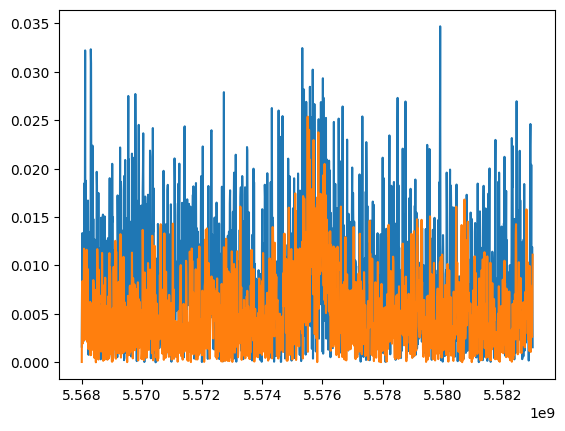

In [2]:
h5file_10 = h5py.File('Values_different_frequency_sweeps_105mKFeb_17_2023-17_42_07.h5', 'r')
freq_10, i_10, q_10 = get_single_res_data(h5file_10, 105, freq_window, 1)
h5file_30 = h5py.File('Values_different_frequency_sweeps_103mKFeb_16_2023-16_06_46.h5', 'r')
freq_30, i_30, q_30 = get_single_res_data(h5file_30, 103, freq_window, 1)

amp_10 = ampl(i_10, q_10)/np.max(ampl(i_10, q_10))
amp_30 = ampl(i_30, q_30)/np.max(ampl(i_30, q_30))

nearby_diff_10 = abs(amp_10 - np.append(amp_10[1:1601], [0]))
nearby_diff_30 = abs(amp_30 - np.append(amp_30[1:1601], [0]))

plt.plot(freq_30[:1600], nearby_diff_30[:1600])
plt.plot(freq_10[:1600], nearby_diff_10[:1600])

We can see, by focusing on a range of frequencies far away from the resonance (this is fundamental: in this region background noise is highly dominating when passing from a frequency point to the next), that background noise is reduced by about a factor of $2$. We should the information stored in the arrays we defined in the code cell above ($\textit{nearby\_diff\_30}$ and $\textit{nearby\_diff\_10}$) to recover a good estimation for the uncertainty. A good idea would be to compute the average value of these arrays (we ensured they are positive - definite, so indeed we are computing an average error). Let's now proceed and open the data files. First of all we define the temperatures we are going to analyse and after which we named our datasets.

In [3]:
#Set parameters to open the correct file and define necessary variables
temps = np.arange(35, 120, 5)  
temps = np.append(temps, np.arange(33, 113, 5))     
temps = np.append(temps, np.arange(118, 208, 5))
temps = np.append(temps, np.arange(208, 248, 10))
#temps = np.append(temps, np.arange(288, 358, 10))

temps = np.sort(temps)
ttemps = temps #temporary variable to store temps. It will be useful later.

In [4]:

def fit_amp_data(f_transl, amp, amp_err, amp_model, k):               #Performs the fit on our data for a single resonance.
    least_squares = LeastSquares(f_transl, amp, amp_err, amp_model)
    m = Minuit(least_squares, p1 = 1, p2 = 1e3, p3 = 4e4, p4 = -0.5, p5 = 0, p6 = 1e-9,  p7 = -1e-19, p8 = -1e-27)
    m.limits['p5'] = (-0.002*1e9, 0.002*1e9)                                #Every resonator likes his own starting points and parameters limits.

    if k == 0:
        m.values['p2'] = 5e4
        m.values['p3'] = 4e5
        m.limits['p2'] = (1e2, 1e6)
        m.limits['p3'] = (1e3, 1e7)
        m.limits['p6'] = (-1e-6, 1e-6)
        m.limits['p7'] = (-1e-13, 1e-13)
        m.limits['p8'] = (-1e-22, 1e-22)

    elif k == 1:
        m.values['p3'] = 7e4
        m.limits['p2'] = (1e2, 1e6)
        m.limits['p3'] = (1e3, 1e7)
        m.limits['p6'] = (-1e-7, 1e-7)
        m.limits['p7'] = (-1e-17, 1e-17)
        m.limits['p8'] = (-1e-27, 1e-27)

    elif k == 2:
        m.limits['p2'] = (1e3, 5e7)
        m.limits['p3'] = (5e3, 1e7)
        m.limits['p6'] = (-1e-7, 1e-7)
        m.limits['p7'] = (-1e-17, 1e-17)
        m.limits['p8'] = (-1e-27, 1e-27)

    elif k == 3:
        m.limits['p2'] = (1e3, 5e4)
        m.limits['p3'] = (5e3, 1e5)
        m.limits['p6'] = (-1e-7, 1e-7)
        m.limits['p7'] = (-1e-17, 1e-17)
        m.limits['p8'] = (-1e-27, 1e-27)

    fit = m.migrad()
    #print(m)
    return fit, m

amp = np.zeros(1601)
Q_i = np.zeros(shape = (len(temps),4))
Q_i_err = np.zeros(shape = (len(temps),4))
kork = np.zeros(shape = (len(temps),4))     #Kill or keep. It stores all the eventual bad points for our final fit.
date = np.array(['Feb_16_2023-15_10_57', 'Feb_17_2023-17_42_07','Feb_16_2023-16_06_46', 'Feb_17_2023-10_01_04', 'Feb_17_2023-11_17_43', 'Feb_17_2023-14_19_39', 'Feb_17_2023-15_43_52', 'Feb_17_2023-15_56_04' ])
j = 0           # index that counts the temperatures
res_freqs = np.zeros(4)

#Here we can eventually examine some specific cases for certain temperatures, or simply analize a random sample of two

select = np.random.choice(temps)

for temp in ttemps:       
    i = 0

    while i < len(date):        #Open the correct hdf5 file
        try:
            h5file = h5py.File('Values_different_frequency_sweeps_' + str(temp) + 'mK' + str(date[i]) + '.h5', 'r')
            break
        except:
            try: 
                h5file = h5py.File('sweeps_' + str(temp) + 'mK' + str(date[i]) + '.h5', 'r')
                break
            except: i +=1

    for k in range(4):      #Access the data in the file of the specified temperature. Store the data of all 4 resonators

        f, i, q = get_single_res_data(h5file, temp, freq_window, k)

        amp = ampl(i,q)
        amp = amp / max(amp)

        amp_err = np.append(amp[1:1601], [0])
        amp_err = np.average(np.abs(amp[:1600] - amp_err[:1600]))
        
        f_min = f[np.where(amp == min(amp))]
        f_transl = f - f_min        #This translation helps the fitting procedure. Purely computational, no physical meaning. The resonance frequency sits now at zero.                    
        

        fit, m = fit_amp_data(f_transl, amp, amp_err, amp_model, k)     #Perform the fit of the resonance profile with our model
        valid, accurate = fit_check(m)
        
        Q_i[j][k] = fit.values["p3"]
        error_p3 = fit.errors["p3"]
        Q_i_err[j][k] = error_p3

        if (valid == False or accurate == False):      
            print('Problem encountered at temp ' + str(temp) + ' mK of the resonance number ' + str(k+1) + '.' )
            kork[j][k] = temp       #Kill all non-convergent fits           

        if (0.05*Q_i[j][k] < Q_i_err[j][k]) or (j > 1 and (Q_i[j][k]/Q_i[j-1][k]) > 10) or (j > 1 and (Q_i[j][k]/Q_i[j-1][k]) < 0.01):      
            kork[j][k] = temp       #Kill highly deviating points or parameters with an error higher than 5%
        
        if (m.values['p3'] < m.values['p2']):
            print('Weird parameters in ' + str(k) + 'th resonator, ' + str(temp) + 'mK: Total Q value should be lower than Internal Q Value. ')

        if (k == 9):        #For a certain value of k = 0,1,2,3 plot everything important
            print('Il valore di Q_i per il risonatore numero ' + str(k) + ' e per la temperatura ' + str(temp) + 'mK è:' + str(Q_i[j][k]) + '+-' + str(Q_i_err[j][k]))
            plot_data_and_fit(f_transl, amp, amp_model(f_transl, *m.values))

        if temp == min(temps):
            res_freqs[k] = f_min
    
    print('temp ' + str(temp) + 'mK done')
    h5file.close()
    j += 1

inv_Q_i = 1 / Q_i
inv_Q_i_err = Q_i_err / Q_i / Q_i
temps = 1e-3*ttemps  #We must rescale temperatures because they have to be expressed in Kelvins (and not mK) when we want to fit


temp 33mK done
temp 35mK done
temp 38mK done
temp 40mK done
temp 43mK done
temp 45mK done
temp 48mK done
temp 50mK done
temp 53mK done
temp 55mK done
temp 58mK done
temp 60mK done
temp 63mK done
temp 65mK done
temp 68mK done
temp 70mK done
temp 73mK done
temp 75mK done
temp 78mK done
temp 80mK done
temp 83mK done
temp 85mK done
temp 88mK done
temp 90mK done
temp 93mK done
temp 95mK done
temp 98mK done
temp 100mK done
temp 103mK done
temp 105mK done
temp 108mK done
temp 110mK done
temp 115mK done
temp 118mK done
temp 123mK done
temp 128mK done
temp 133mK done
temp 138mK done
temp 143mK done
temp 148mK done
temp 153mK done
temp 158mK done
temp 163mK done
temp 168mK done
temp 173mK done
temp 178mK done
temp 183mK done
temp 188mK done
temp 193mK done
temp 198mK done
temp 203mK done
temp 208mK done
temp 218mK done
temp 228mK done
temp 238mK done


In [5]:
print(kork) #To have an idea of what exactly we have killed

[[ 33.   0.   0.   0.]
 [ 35.   0.   0.   0.]
 [ 38.   0.   0.   0.]
 [ 40.   0.   0.   0.]
 [ 43.   0.   0.   0.]
 [  0.   0.   0.   0.]
 [ 48.   0.   0.   0.]
 [ 50.   0.   0.   0.]
 [ 53.   0.   0.   0.]
 [ 55.   0.   0.   0.]
 [ 58.   0.   0.   0.]
 [ 60.   0.   0.   0.]
 [ 63.   0.   0.   0.]
 [ 65.   0.   0.   0.]
 [ 68.   0.   0.   0.]
 [ 70.   0.   0.   0.]
 [ 73.   0.   0.   0.]
 [ 75.   0.   0.   0.]
 [ 78.   0.   0.   0.]
 [ 80.   0.   0.   0.]
 [ 83.   0.   0.   0.]
 [ 85.   0.   0.   0.]
 [ 88.   0.   0.   0.]
 [ 90.   0.   0.   0.]
 [ 93.   0.   0.   0.]
 [ 95.  95.   0.   0.]
 [ 98.   0.   0.   0.]
 [100.   0.   0.   0.]
 [103.   0.   0.   0.]
 [105.   0.   0.   0.]
 [108.   0.   0.   0.]
 [110.   0.   0.   0.]
 [115.   0.   0.   0.]
 [118.   0.   0.   0.]
 [123.   0.   0.   0.]
 [128.   0.   0.   0.]
 [133.   0.   0.   0.]
 [138.   0.   0.   0.]
 [143.   0.   0.   0.]
 [148.   0.   0.   0.]
 [153.   0.   0.   0.]
 [158.   0.   0.   0.]
 [163.   0.   0.   0.]
 [168.   0.

$\color{blue}\textbf{Second fit:} \\$
$\textbf{Remember that you have to mediate on the four resonators sooner or later}$, in order to account for small differences in the vaues stimated for $Q_i$. Now we want to fit the graph we obtained.$\\$
From the second fit we want to get the value of the gap parameter at 0 K $[\Delta(0)]$ for our superconductor.

The interpolating function we will use is $\begin{equation}
\frac{1}{Q_i(T)} = \frac{1}{Q_i(0)} + \frac{\sigma_{1}}{\sigma_{2}} \simeq \frac{1}{Q_i(0)} + \frac{2\alpha}{\pi}\frac{e^{-\frac{\Delta (0)}{k_{B} T}}K_{0}(\frac{\hbar \omega}{2 k_{B} T})\Big[ 2 \sinh (\frac{\hbar \omega}{2 k_{B} T})\Big]}{\Big[1 - 2 e^{-\frac{\Delta (0)}{k_{B}T}}e^{-\frac{\hbar \omega}{2 k_{B} T}} I_{0}(\frac{\hbar \omega}{2 k_{B}T}) \Big]} \end{equation} \\$
Is the $\omega$ the (angular) resonance frequency of the oscillator? In that case it varies with T and you could account for it when you do the fit.


45 point(s) removed
RESONATOR NUMBER  1
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 6.909e+04 (chi2/ndof = 11514.4)│              Nfcn = 269              │
│ EDM = 1.08e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │       SOME Parameters at limit       │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────

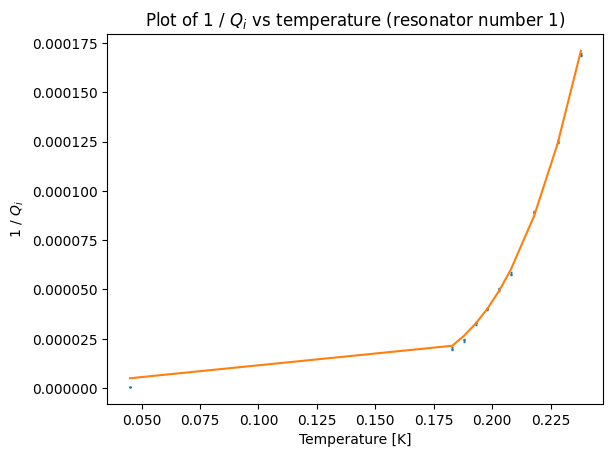

The interpolated value of the gap parameter is: ( 2.5629915924695177e-23 +- 1.4975457119279656e-25 ) J
In terms of eV, it is: ( 0.16018697452934488 +- 0.0009359660699549785 ) meV

1 point(s) removed
RESONATOR NUMBER  2
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 156.5 (chi2/ndof = 3.1)    │              Nfcn = 267              │
│ EDM = 1.08e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │    

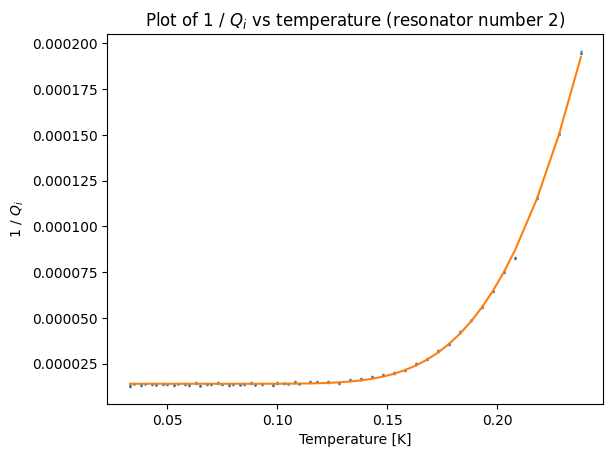

The interpolated value of the gap parameter is: ( 2.0862402530497396e-23 +- 8.573127949757399e-26 ) J
In terms of eV, it is: ( 0.13039001581560872 +- 0.0005358204968598375 ) meV

0 point(s) removed
RESONATOR NUMBER  3
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 210.8 (chi2/ndof = 4.1)    │              Nfcn = 355              │
│ EDM = 2.7e-05 (Goal: 0.0002)     │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     

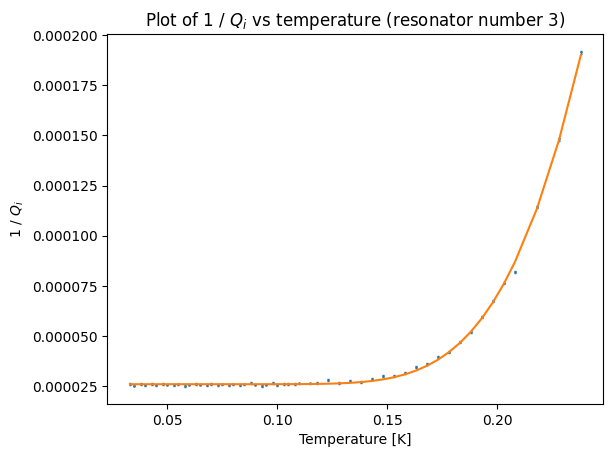

The interpolated value of the gap parameter is: ( 2.306878697624496e-23 +- 9.777397372046804e-26 ) J
In terms of eV, it is: ( 0.144179918601531 +- 0.0006110873357529252 ) meV

0 point(s) removed
RESONATOR NUMBER  4
┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 851.5 (chi2/ndof = 16.7)   │              Nfcn = 300              │
│ EDM = 6.41e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hes

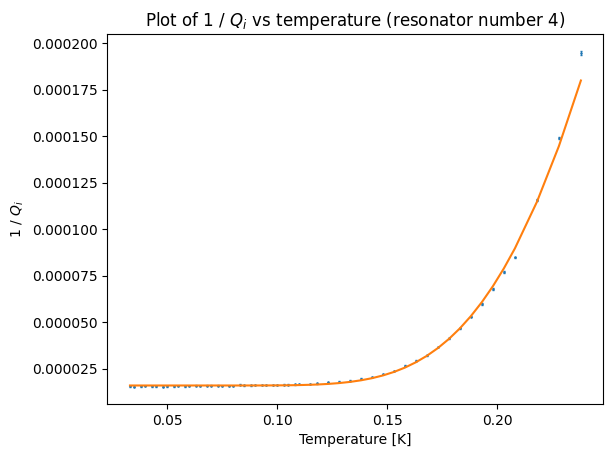

The interpolated value of the gap parameter is: ( 1.8639372048438864e-23 +- 5.299317893014046e-26 ) J
In terms of eV, it is: ( 0.11649607530274292 +- 0.00033120736831337787 ) meV

Recap:
delta (mev) = [0.16018697 0.13039002 0.14417992 0.11649608]
errors (mev) =  [0.00093597 0.00053582 0.00061109 0.00033121]


In [6]:

def fit_Qi_vs_temp(temp, inv_Q_i, inv_Q_i_err, suggestions):
    least_squares = LeastSquares(temp, inv_Q_i, inv_Q_i_err, inv_Qi_model)
    m = Minuit(least_squares, p1 = suggestions[0 , res], p2 = suggestions[3 , res], p3 = suggestions[6 , res], p4 = suggestions[11, res])  # starting values for our parameters
    m.limits['p1'] = (suggestions[1 , res], suggestions[2 , res])           
    m.limits['p2'] = (suggestions[4 , res], suggestions[5 , res])
    m.limits['p3'] = (suggestions[7 , res], suggestions[8 , res])
    #m.limits['p4'] = ((suggestions[9 , res], suggestions[10 , res]))
    fit = m.migrad()        #This is the command that performs the fit
    return fit, m 

# Erase these lines when you're done with trial and error

suggestions_fit_inv_Q_i = np.zeros(shape=(12, 4))           # Attempt to automatize fit suggestions. Order of the array is: p_i_sugg, p_i_liminf, p_i_limsup for i in [1,3] and in the end p_4_sugg
suggestions_fit_inv_Q_i[:,0] = np.array([3.5e5, 30e3, 2e5, .85, 0.01, 0.99, 2.6e-23, 1e-23, 5e-23, 2*np.pi*freq_window[0]*1e9, 2*np.pi*freq_window[1]*1e9, 2* np.pi *5e9])
suggestions_fit_inv_Q_i[:,1] = np.array([7e4, 50e3, 90e3, .85, 0.01, 0.99, 2.6e-23, 1.7e-23, 5e-23, 2*np.pi*freq_window[2]*1e9, 2*np.pi*freq_window[3]*1e9, 2* np.pi *5e9]) 
suggestions_fit_inv_Q_i[:,2] = np.array([4e4, 30e3, 50e3, .85, 0.01, 0.99, 2.6e-23, 1.7e-23, 5e-23, 2*np.pi*freq_window[4]*1e9, 2*np.pi*freq_window[5]*1e9, 2* np.pi *5e9]) 
suggestions_fit_inv_Q_i[:,3] = np.array([6e4, 10e3, 90e3, .85, 0.01, 0.99, 2.6e-23, 1.7e-23, 5e-23, 2*np.pi*freq_window[6]*1e9, 2*np.pi*freq_window[7]*1e9, 2* np.pi *5e9])  

# Trying to fit

delta = np.zeros(shape = Q_i[0,:].shape)
delta_err = np.zeros(shape = Q_i[0,:].shape)

res = 0
indexes = np.empty(0)

for k in range(4):

    inv = inv_Q_i[:55, k]
    inv_err = inv_Q_i_err[:55, k]

    for j in range(len(ttemps)):
        if kork[j][k] == ttemps[j]:
            indexes = np.append(indexes, [j])
    
    indexes = np.asarray(indexes, dtype = 'int')
    temps = np.delete(temps, indexes)
    inv = np.delete(inv, indexes)
    inv_err = np.delete(inv_err, indexes)
    print(str(len(ttemps) - abs(len(indexes) - len(ttemps))) + ' point(s) removed')  

    fit, m = fit_Qi_vs_temp(temps, inv, inv_err, suggestions_fit_inv_Q_i)        # Fit execution

    valid, accurate = fit_check(m)             #Fit check
    print('RESONATOR NUMBER ', k+1)

    if(valid == False or accurate == False):
        print('There has been some trouble with the fit of the resonance number ' + str(k+1) +'. \n Make a check!' )
    print(fit)
    
    plot_data_and_fit(temps, inv, inv_Qi_model(temps, *m.values), inv_err, x_axis = 'Temperature [K]', y_axis = '1 / $Q_i$', title = 'Plot of 1 / $Q_i$ vs temperature (resonator number ' + str(k+1) + ')')
        
    delta[k]= fit.values["p3"]                  #Get the delta parameter
    delta_err[k] = fit.errors["p3"]

    print('The interpolated value of the gap parameter is: (', delta[k], '+-', delta_err[k], ') J')
    print('In terms of eV, it is: (', delta[k] / ( 1.6e-19) * 1e3, '+-', delta_err[k] / ( 1.6e-19) * 1e3,') meV\n' )
    temps = ttemps*1e-3
    indexes = np.empty(0)
    res += 1

print('Recap:')
print('delta (mev) =', delta/ ( 1.6e-19) * 1e3)
print('errors (mev) = ', delta_err/ ( 1.6e-19) * 1e3)

In [7]:
gap_measured = np.average(delta) / (1.6e-19) * 1000 
sqrt_error_gap_measured = np.std(delta) / (1.6e-19) * 1000

print('The measured value of the gap is (averaged on the 4 reonances and withs std error): (', gap_measured, '+-', sqrt_error_gap_measured, ') mev')

T_c = 0.9
gap_0K = 1.764 * sc.k * T_c
print('BCS predicts (if T_c =', T_c,  'K) a gap of : ', gap_0K / (1.6e-19) * 1000, 'mev or ', gap_0K, 0 ,'J')



The measured value of the gap is (averaged on the 4 reonances and withs std error): ( 0.1378132460623069 +- 0.016206822338342267 ) mev
BCS predicts (if T_c = 0.9 K) a gap of :  0.13699489702500003 mev or  2.1919183524000003e-23 0 J
